# Correlation visualizations

Exploration on correlations and possibly other interesting connectivity measures obtained from the raw timeseries.

In [2]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv(f'../data/patients-cleaned.csv', index_col=0)
print('Samples: ', df.shape[0])
df.head()

Samples:  190


,age,sex,target
0,24.750,1,0
1,27.667,1,0
2,34.167,1,0
3,28.917,1,0
4,31.917,0,0


In [5]:
with open('../data/timeseries.pickle', 'rb') as f:
    ts = pickle.load(f)

num_subjects, num_regions, num_points = ts.shape

print(f'Subjects: {num_subjects}')
print(f'Brain regions: {num_regions}')
print(f'Timeseries length: {num_points}')

Subjects: 190
Brain regions: 90
Timeseries length: 400


In [6]:
with open('../data/cache/raw_matrices_pearson.pickle', 'rb') as f:
    fc_pearson = pickle.load(f)

with open('../data/cache/raw_matrices_spearman.pickle', 'rb') as f:
    fc_spearman = pickle.load(f)

with open('../data/cache/raw_matrices_xi.pickle', 'rb') as f:
    fc_xi = pickle.load(f)

In [7]:
target_index_change = 90 # From controls to patients.

## Heatmaps

In [8]:
def plot_correlations(subject, fc=fc_pearson):
    """
    Displays heatmap of `subject's`th fc matrix.
    """
    sns.heatmap(fc[subject], cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Subject [{subject}] - {'control' if subject < target_index_change else 'patient'}")
    plt.show()

def plot_variances(start=0, end=-1, fc=fc_pearson):
    """
    Plots variance of covariances on samples from `fc[start:end]`.
    """
    correlations = fc[start:end]
    variances = np.var(correlations, axis=0)    
    sns.heatmap(variances, cmap="Reds", vmin=0, vmax=0.1)
    plt.title(f"Subjects [{start} - {end}] variance in correlations")
    plt.show()

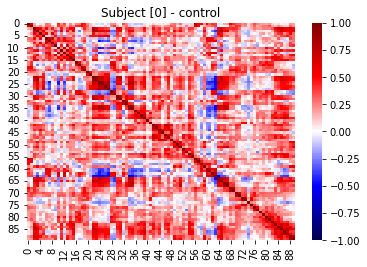

In [9]:
plot_correlations(0)

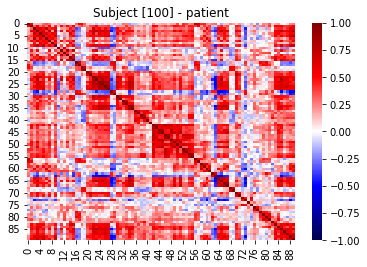

In [11]:
plot_correlations(100)

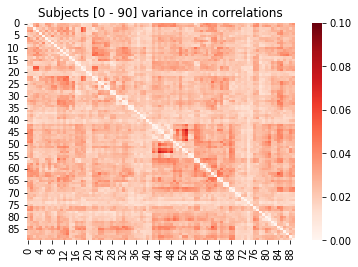

In [12]:
plot_variances(end=target_index_change)

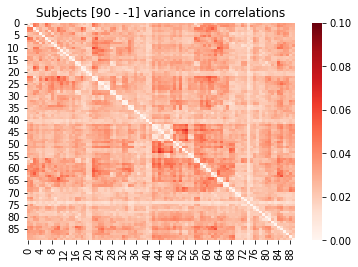

In [13]:
plot_variances(start=target_index_change)

### Average heatmaps per group

In [14]:
fc = fc_pearson.copy()

In [15]:
avg_fc_control = np.mean(fc[0:target_index_change], axis=0)
avg_fc_patient = np.mean(fc[target_index_change:], axis=0)
avg_fc_diff = avg_fc_control - avg_fc_patient

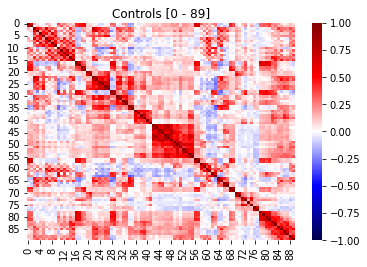

In [18]:
sns.heatmap(avg_fc_control, cmap="seismic", vmin=-1, vmax=1)
plt.title(f"Controls [0 - {target_index_change-1}]")
plt.show()

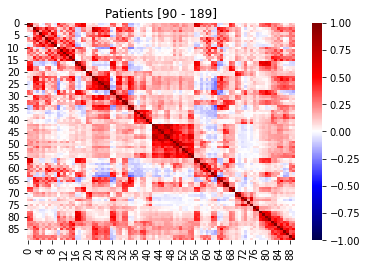

In [19]:
sns.heatmap(avg_fc_patient, cmap="seismic", vmin=-1, vmax=1)
plt.title(f"Patients [{target_index_change} - {df.shape[0] - 1}]")
plt.show()

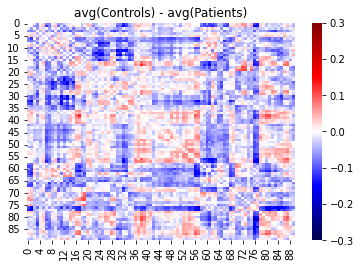

In [20]:
sns.heatmap(avg_fc_diff, cmap="seismic", vmin=-0.3, vmax=0.3)
plt.title("avg(Controls) - avg(Patients)")
plt.show()

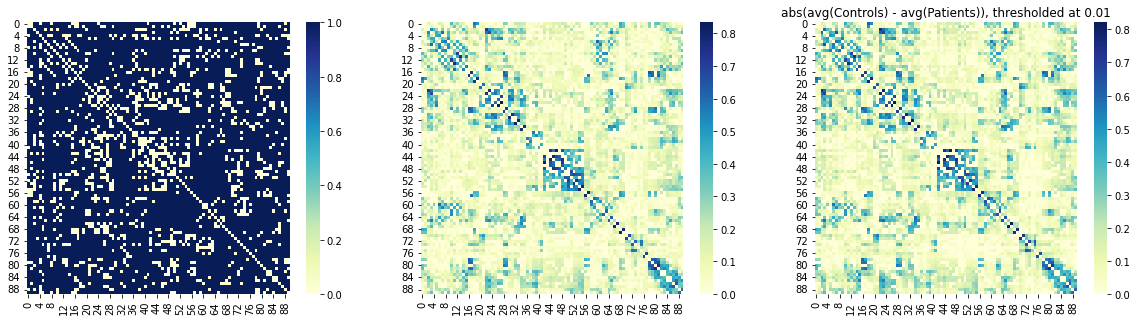

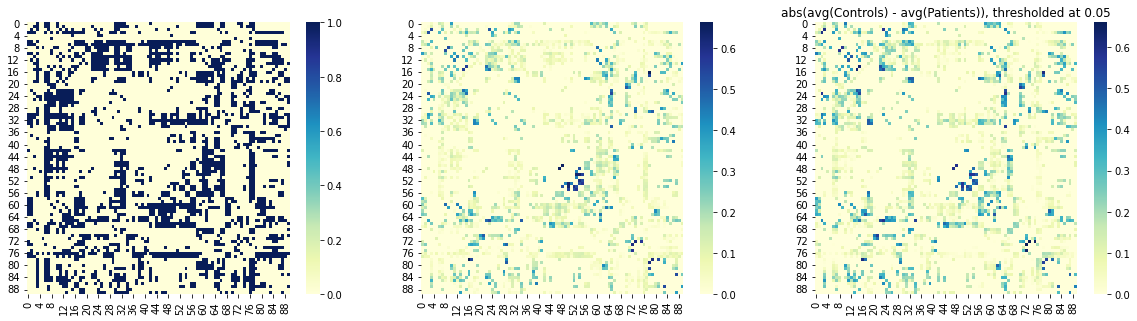

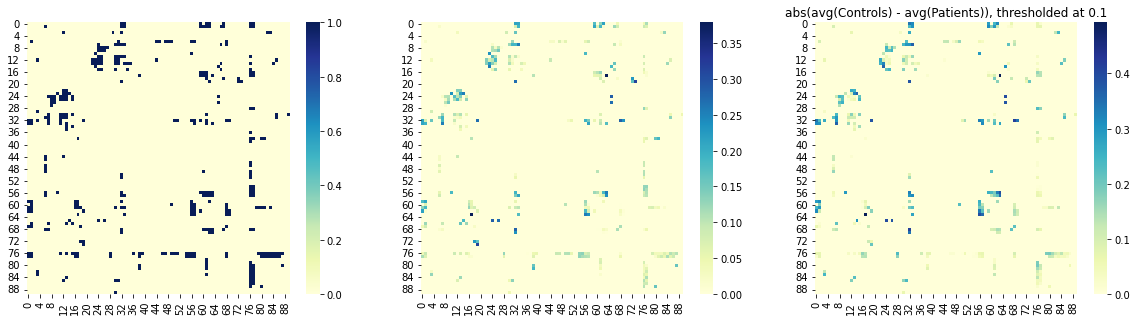

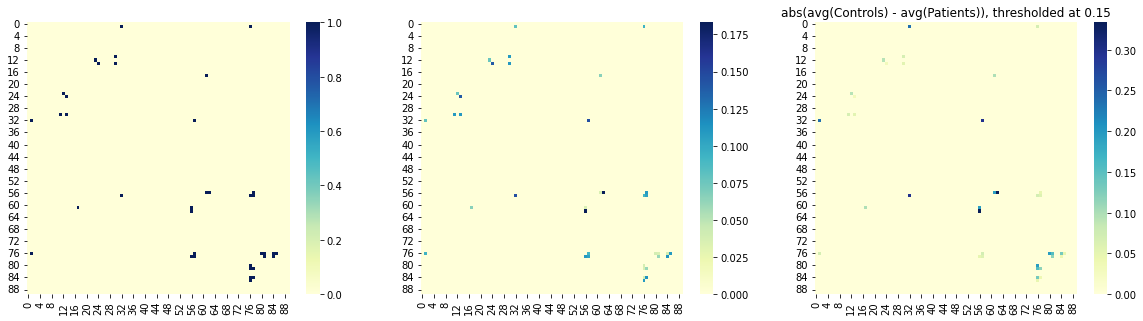

In [73]:
for min_diff_threshold in [0.01, 0.05, 0.1, 0.15]:
    fc_diff_thresholded = np.where(np.abs(avg_fc_diff) > min_diff_threshold, True, False)

    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    sns.heatmap(fc_diff_thresholded, cmap="YlGnBu", ax=ax[0])
    sns.heatmap(np.where(fc_diff_thresholded, np.abs(avg_fc_control), 0), cmap="YlGnBu",ax=ax[1])
    sns.heatmap(np.where(fc_diff_thresholded, np.abs(avg_fc_patient), 0), cmap="YlGnBu", ax=ax[2])

    plt.title(f"abs(avg(Controls) - avg(Patients)), thresholded at {min_diff_threshold}")
    plt.show()

## Histograms

In [48]:
def plot_histogram(subject, fc=fc_pearson, bins=num_regions):
    """
    Displays histogram of `subject's`th fc matrix.
    """
    data = fc[subject].reshape(-1)
    plt.hist(data, bins=bins, alpha=0.5)
    plt.axvline(np.mean(data), c='k')
    plt.axvline(np.mean(data) + np.std(data), c='r')
    plt.axvline(np.mean(data) - np.std(data), c='r')
    plt.title(f"Subject [{subject}] - {'control' if subject < target_index_change else 'patient'}")

    plt.xlim([-1, 1])   # Fix for easier eye inspection.
    plt.show()

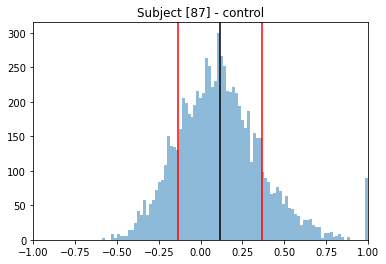

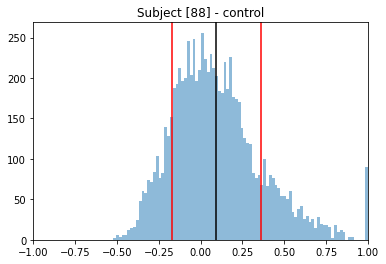

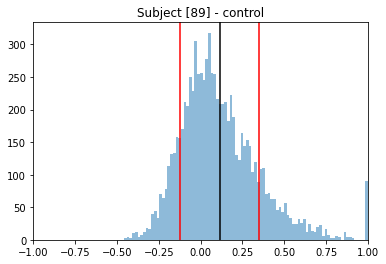

In [64]:
for i in range(target_index_change-3,target_index_change):
    plot_histogram(i)

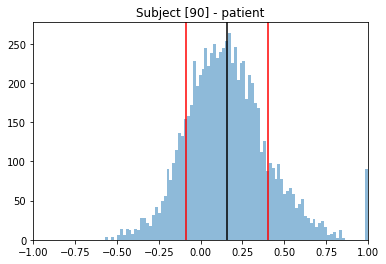

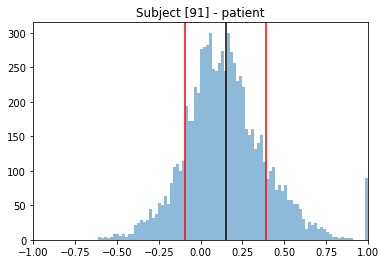

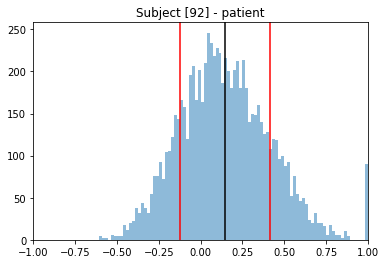

In [63]:
for i in range(target_index_change, target_index_change+3):
    plot_histogram(i)

### Average histograms per group

In [51]:
fc = fc_pearson.copy()

In [46]:
avg_fc_control = np.mean(fc[0:target_index_change], axis=0).reshape(-1)
avg_fc_patient = np.mean(fc[target_index_change:len(df)], axis=0).reshape(-1)

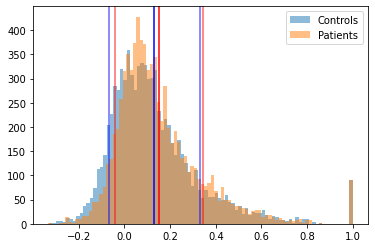

In [52]:
plt.hist(avg_fc_control, bins=num_regions, label='Controls', alpha=0.5)
plt.hist(avg_fc_patient, bins=num_regions, label='Patients', alpha=0.5)

plt.axvline(np.mean(avg_fc_control), c='b')
plt.axvline(np.mean(avg_fc_control) + np.std(avg_fc_control), c='b', alpha=0.6)
plt.axvline(np.mean(avg_fc_control) - np.std(avg_fc_control), c='b', alpha=0.6)

plt.axvline(np.mean(avg_fc_patient), c='r')
plt.axvline(np.mean(avg_fc_patient) + np.std(avg_fc_patient), c='r', alpha=0.6)
plt.axvline(np.mean(avg_fc_patient) - np.std(avg_fc_patient), c='r', alpha=0.6)

plt.legend()
plt.show()

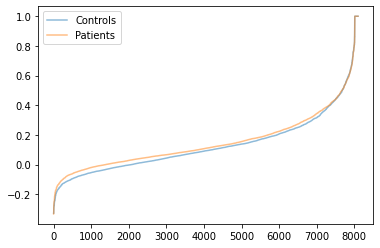

In [53]:
plt.plot(range(num_regions**2), sorted(avg_fc_control), label='Controls', alpha=0.5)
plt.plot(range(num_regions**2), sorted(avg_fc_patient), label='Patients', alpha=0.5)
plt.legend()
plt.show()

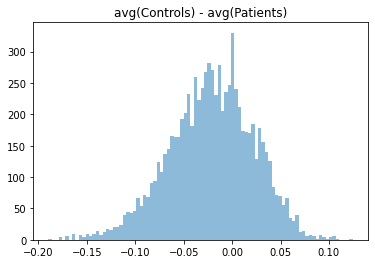

In [54]:
avg_difference = np.mean(fc[0:target_index_change], axis=0) - np.mean(fc[target_index_change:len(df)], axis=0)

plt.hist(avg_difference.reshape(-1), bins=num_regions, alpha=0.5)
plt.title("avg(Controls) - avg(Patients)")
plt.show()

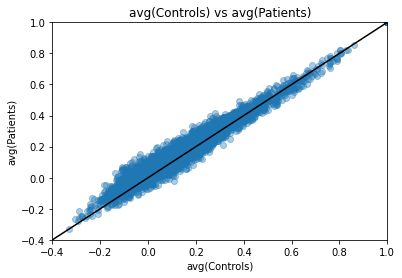

In [55]:
plt.scatter(avg_fc_control, avg_fc_patient, alpha=0.2)

axis_limit = [-0.4, 1]
plt.plot(axis_limit, axis_limit, c='k')
plt.ylim(axis_limit)
plt.xlim(axis_limit)

plt.xlabel("avg(Controls)")
plt.ylabel("avg(Patients)")
plt.title("avg(Controls) vs avg(Patients)")
plt.show()

## 2D embedding visualization

In [56]:
fc = fc_pearson.copy()

In [57]:
fc_diag = [np.hstack([fc_row[:i] for i, fc_row in enumerate(fc_sample)]) for fc_sample in fc]

In [61]:
# fc_embedded = TSNE(n_components=2, perplexity=5, learning_rate=100, n_iter=5000).fit_transform(fc_diag)
fc_embedded = PCA(n_components=2).fit_transform(fc_diag)

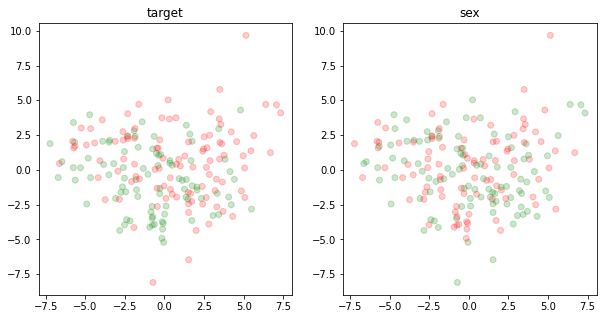

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
colors = ['g' if i==0 else 'r' for i in df['sex'].values]

ax[0].set_title('target')
colors = ['g' if i==0 else 'r' for i in df['target'].values]
ax[0].scatter(fc_embedded[:, 0], fc_embedded[:, 1], alpha=0.2, c=colors)

ax[1].set_title('sex')
colors = ['g' if i==0 else 'r' for i in df['sex'].values]
ax[1].scatter(fc_embedded[:, 0], fc_embedded[:, 1], alpha=0.2, c=colors)

plt.show()